In [1]:
import pandas as pd
import os
from math import *
import re
from datetime import datetime, date, time, timedelta
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from MPT_utils import * 
import cvxpy as cvx
import numpy as np

In [2]:
#universe = ['spy','ark'] 
universe = ['spy']
#universe = ['ark']

#variables for data download
hist_window = 100 #for historical pricing
date_fmt = '%Y-%m-%d'
start_date = datetime.now() - timedelta(hist_window)
start_date = start_date.strftime(date_fmt)
sleep_time = 5
lb = 55; min_gross=0.5; max_gross=1; min_w=0; max_w=0.05 # default optimization vars
refresh_pricing = False

config = {'spy' : {
            'benchmark': 'spy',
            'skiprows': 1,
            'columns': ['Symbol', 'Company Name']},
        'ark' : {
            'benchmark': 'ark' ,
            'skiprows': 0,
            'columns': ['ticker','company']}}

pricing_path = "./pricing/"
component_path = "./sector_components/"
## Script que obtiene los datos de las fuentes:
# 1. Sector components   : Contiene la información de los ETF sectors y sus componentes
# 2. Pricing            : Contiene la informacion historica de precios de cada uno de los componentes
# 3. Optimizacion de Markowitz
# 4. Seleccion de subportafolio
# 5. Rebalanceo


1. Sector Components

In [3]:
### 1. Sector components:
# de donde se extrae esta info, con que frecuencia se actualiza?

## 1.1 descargar componentes del server:

## 1.2 cargar los sector componentes para cada benchmark, cargar cada ETF sector para cada benchmark
# y cada company para cada ETF sectior y limpiarlos

companies_universe= pd.DataFrame({}) ### contiene todas las compañias del etf sector para cada benchmark
sector_etf = {}   ### contiene cada etf sector para cada benchmark
ticker_map= {}    ### contiene todas las compañias para cada etf sector 

for k in universe:
    #print(config[k])
    companies,benchmark_etf_map,sector_tickers_map=load_companies(benchmark=config[k]['benchmark'],skiprows=config[k]['skiprows'],columns=config[k]['columns']) ## companies del benchmark spy
    print("Companies loaded:",config[k]['benchmark'], companies.shape)
    companies_universe=companies_universe.append(companies)
    sector_etf.update(benchmark_etf_map)
    ticker_map.update(sector_tickers_map)

loaded: xlb
loaded: xle
loaded: xlf
loaded: xli
loaded: xlk
loaded: xlp
loaded: xlre
loaded: xlu
loaded: xlv
loaded: xly
Companies loaded: spy (505, 3)


2 Pricing

In [4]:

# 2. Pricing            : Contiene la informacion historica de precios de cada uno de los componentes

## 2.1 descargar componentes del server:

if refresh_pricing==True:
    ### refresh components
    etfs=[ [i,j,ticker_map[j]] for i in universe for j in sector_etf[i] ]
    for i in etfs:
        get_pricing(output_name=pricing_path+i[0]+"/"+i[1]+"-hold-pricing.csv",
        ticker_list=i[2],start_date=start_date)
    ## refresh etf sectors 
    sectors=[[i,sector_etf[i]] for i in universe]
    for j in sectors:
        get_pricing(output_name=pricing_path+j[0]+"/"+j[0]+'-sectors.csv', 
        ticker_list=j[1], start_date=start_date)
    # refresh benchmarks
    benchmarks=[i for i in universe]
    #benchmarks
    for j in benchmarks:
        print(j)
        get_pricing(output_name=pricing_path+ j +'/'+j+'.csv', ticker_list=j, start_date=start_date)


### consol_px contiene los precios historicos de cada compañia
consol_px=load_consol_px(universe)
consol_px=consol_px[sorted(consol_px.columns.tolist())]
print("consol_px"+str(consol_px.shape))
### crear consol_px 

    
# #### Limpiar las compañias que tienen valores nulos en los ultimos 3 dias y valores nulos en toda su serie
consol_px,cols=clean_nas(consol_px) ## limpia de aquellos valores que no tienen valores en su serie o que por alguna razon tienen NAN en los ultimos dias
print("se limpio consol_px"+str(consol_px.shape))
print("se borraron:")
print(cols)


# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN'] # example: two M&A targets, diff share classes...
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0:
    consol_px.drop(remove, axis=1, inplace=True)

consol_px.to_csv("consol_mpt_opt.csv")
print("consol_px final: "+str(consol_px.shape))

spy
consol_px(69, 505)
se limpio consol_px(69, 501)
se borraron:
BF.B     69
BKNG     55
BRK.B    69
SNI       6
dtype: int64
consol_px final: (69, 495)


3. Optimización

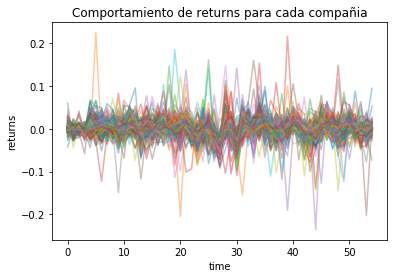

In [5]:
# 3. Optimizacion

px_portion = consol_px[-abs(hist_window):].copy() ## tomar los ultimos hist_window rows de la tabla de precios
px_portion= px_portion.sort_index().pct_change(); px_portion.iloc[0] = 0 ## calcular returns
return_vec =px_portion.loc[:px_portion.tail(1).index[0]].tail(lb)#.dropna()

### grafico de comportamientos de returns
plot_returns(return_vec)


In [6]:

######## OPTIMIZACION COMPLETA DE PORTAFOLIO
# Compute trade-off curve.
min_weight=0.01
SAMPLES = 100
w = []
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
sharpe = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
risk_data_sub = np.zeros(SAMPLES)
ret_data_sub = np.zeros(SAMPLES)
sharpe_sub = np.zeros(SAMPLES)
w_sub = []
for i in range(SAMPLES):
    risk,ret,w_,mu,Sigma,name=Optimization(return_vec,i)
    risk_data[i] = risk
    ret_data[i]= ret
    w.append(w_)
    sharpe[i]=ret/risk
    #idx_opt_gamma = [sharpe.tolist().index(i) for i in sorted(sharpe)[-1:]][0]
    portfolio_opt = pd.DataFrame(w_,index=name,columns=["Allocation"])
    return_subportfolio,risk_subportfolio,sharpe_subportfolio,weights_subportfolio=get_subportfolio(portfolio_opt,min_weight,px_portion)
    risk_data_sub[i] = risk_subportfolio
    ret_data_sub[i]= return_subportfolio
    w_sub.append(weights_subportfolio)
    sharpe_sub[i]=sharpe_subportfolio

In [7]:
opt_gammas=pd.DataFrame({"gamma":gamma_vals,"return":ret_data,
    "risk":risk_data,"sharpe":sharpe,"% allocation":[sum(w[i]) for i in range(SAMPLES)],"return_sub":ret_data_sub,
    "risk_sub":risk_data_sub,"sharpe_sub":sharpe_sub,"% allocation_sub":[sum(w_sub[i]) for i in range(SAMPLES)]})
opt_df=opt_gammas.sort_values(by='sharpe_sub', ascending=False).head(5)
opt_df.head(5)

,% allocation,% allocation_sub,gamma,return,return_sub,risk,risk_sub,sharpe,sharpe_sub
45,0.5,0.478941,1.873817,0.002362,0.141078,0.005161,0.039409,0.457597,3.579834
44,0.5,0.483110,1.668101,0.002375,0.142057,0.005190,0.039741,0.457614,3.574529
43,0.5,0.487116,1.484968,0.002391,0.142997,0.005226,0.040063,0.457583,3.569294
42,0.5,0.489814,1.321941,0.002400,0.143652,0.005246,0.040295,0.457538,3.565044
41,0.5,0.490054,1.176812,0.002403,0.143744,0.005253,0.040333,0.457509,3.563934


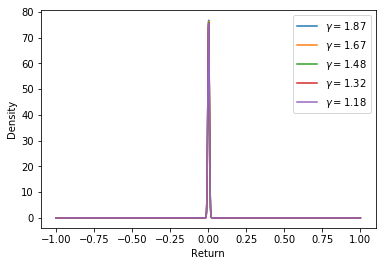

In [15]:
# Plot return distributions for two points on the trade-off curve.
import matplotlib.mlab as mlab
plt.figure()
for idx, row in opt_df.iterrows():
    #print(idx)
    x = np.linspace(-1, 1, 1000)
    plt.plot(x, mlab.normpdf(x, row["return"], row["risk"]), label=r"$\gamma = %.2f$" % row["gamma"])

plt.xlabel('Return')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

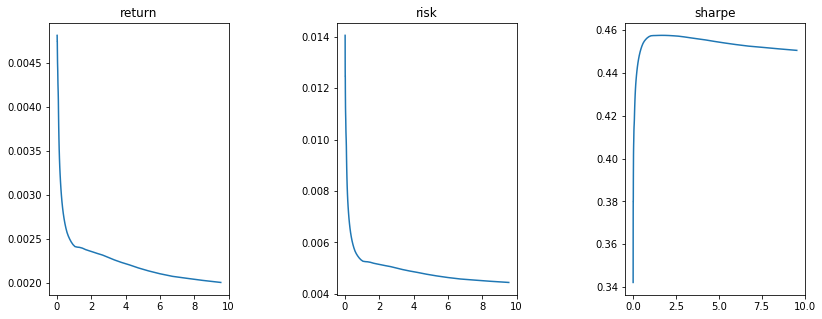

In [16]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(left=0.2, wspace=0.6)
ax1=fig.add_subplot(1,3,1)
ax1.set_title("return")
ax1.plot(opt_gammas["gamma"].values[:60],opt_gammas["return"].values[:60])

ax2=fig.add_subplot(1,3,2)
ax2.set_title("risk")
ax2.plot(opt_gammas["gamma"].values[:60],opt_gammas["risk"].values[:60])

ax3=fig.add_subplot(1,3,3)
ax3.set_title("sharpe")
ax3.plot(opt_gammas["gamma"].values[:60],opt_gammas["sharpe"].values[:60])
plt.show()

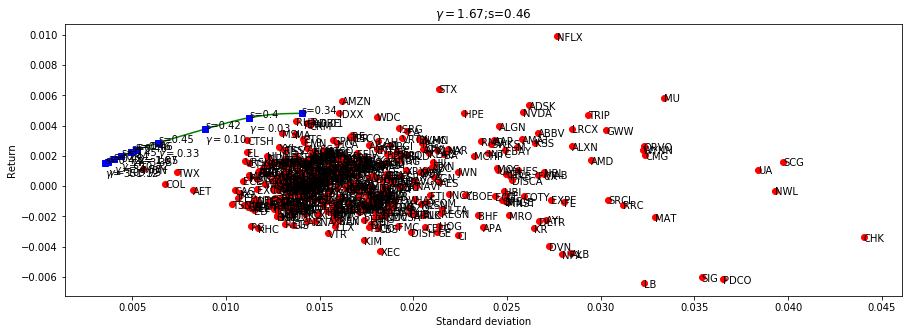

In [17]:
plot_Optimization(risk_data,ret_data,gamma_vals,sharpe,name,Sigma,mu)

1. Elección de subportafolio

In [ ]:
# 4. SELECCION DE SUBCONJUNTO DE PORTAFOLIO


idx_opt_gamma = [sharpe_sub.tolist().index(i) for i in sorted(sharpe_sub)[-1:]][0]
portfolio_opt = pd.DataFrame(w[idx_opt_gamma],index=name,columns=["Allocation"])

return_subportfolio,risk_subportfolio,weights_subportfolio=get_subportfolio(portfolio_opt,min_weight,px_portion)

print("Gamma: {0:.2f}".format(gamma_vals[idx_opt_gamma]))
print("Return Portfolio Optimo completo: "+str(ret_data[idx_opt_gamma]))
print("Risk Portfolio Optimo completo: "+ str(risk_data[idx_opt_gamma]))
print("Sharpe Portfolio Optimo completo: "+ str(sharpe[idx_opt_gamma]))
print("Return Sub-Portfolio Optimo: "+str(return_subportfolio))
print("Risk Sub-Portfolio Optimo: "+ str(risk_subportfolio))
print("Sharpe Sub-Portfolio Optimo: "+ str(return_subportfolio/risk_subportfolio))


recommend =pd.DataFrame(weights_subportfolio)
recommend['Sector'] = pd.DataFrame(companies_universe.loc[recommend.index.values.tolist()]["etf_sector"]).reset_index().drop_duplicates(subset=['ticker', 'etf_sector'], keep="first").groupby('ticker')['etf_sector'].apply(lambda x: "{%s}" % ', '.join(x))
recommend['Company'] = companies_universe.loc[recommend.index.values.tolist()]["company_name"].reset_index().drop_duplicates(subset=['ticker', 'company_name'], keep="first").groupby('ticker')['company_name'].apply(lambda x: "{%s}" % ', '.join(x))
recommend['benchmark'] = pd.DataFrame(companies_universe.loc[recommend.index.values.tolist()]["benchmark"]).reset_index().drop_duplicates(subset=['ticker', 'benchmark'], keep="first").groupby('ticker')['benchmark'].apply(lambda x: "{%s}" % ', '.join(x))


In [14]:
#[sharpe_sub.tolist().index(i) for i in sorted(sharpe_sub)[-1:]][0]
#ret_data_sub
gamma_vals[93]

w_sub[92]
opt_gammas.sort_values(by='sharpe_sub', ascending=False).tail(5)

,% allocation,% allocation_sub,gamma,return,return_sub,risk,risk_sub,sharpe,sharpe_sub
99,0.5,0.476796,1000.000000,0.001425,0.076940,0.003445,0.026070,0.413564,2.951243
2,1.0,1.000000,0.012619,0.004788,0.286164,0.013093,0.100194,0.365695,2.856110
1,1.0,1.000000,0.011233,0.004808,0.287426,0.013718,0.105165,0.350521,2.733085
0,1.0,1.000000,0.010000,0.004809,0.288570,0.014055,0.107321,0.342170,2.688855
93,1.0,0.000000,497.702356,0.001477,0.000000,0.003524,0.000000,0.419294,0.000000


In [ ]:
j=1
n=ceil(consol_px[recommend.index].shape[1]/2)
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(left=0.2, wspace=0.6)
for i in consol_px[recommend.index][-hist_window:].columns:
    ax=fig.add_subplot(2,n,j) 
    ax.set_title(i)
    ax.plot(consol_px[recommend.index][-hist_window:][[i]].values)
    j=j+1
    #print(i)

plt.show()

Rebalanceo

In [ ]:

# Outputs for trade execution
px = consol_px[recommend.index][-lb:]
date = pd.to_datetime(px[-1:].index[0])#.strftime(date_fmt)

trading_cols = ['Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=recommend.index, columns=trading_cols)

port_bal = 231000; 
alloc = weights_subportfolio.T.values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(lambda x: round(x, 0)).T.sort_index()

#trading_df['Company'] = pd.DataFrame(recommend.index)
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Time Window: {}, Lookback: {}, MinGross: {}, MaxGross: {}, MinWeight: {}, MaxWeight: {}".format(hist_window, lb, min_gross, max_gross, min_w, max_w))
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(return_subportfolio, risk_subportfolio, sharpe_subportfolio))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))
trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})
trading_df.sort_index()

